Nome: João Gabriel Andrade de Araujo Josephik NUSP: 12542265

Link do colab: https://colab.research.google.com/drive/1SSCTGkdt_0n-B2PX-3IdhL3AnajlAQT6?usp=sharing


O notebook abaixo contém a resolução do problema MNIST com duas redes neurais diferentes. A primeira é uma rede convolucional e a segunda é fully-connected.
Eu já havia resolvido esse problema antes, com uma rede convolucional. Quando o fiz, usei esse link como referência: https://nextjournal.com/gkoehler/pytorch-mnist. Por isso, alguns trechos do código, principalmente relacionados ao formato da saída, podem ter semelhanças.

Cada rede foi treinada com um otimizador SGD com momentum e com ADAM. Após isso, fiz também uma rede convolucionar com apenas 1379 parâmetros, para comparação. Essa rede foi otimizada com Adam. Em todas elas, o learnig_rate era cortado pela metade a cada 10 épocas.

Resultados:

- Convolucional + SGD: 95% de acurácia

- FCN + SGD: 93% de acurácia

- Convolucional + ADAM: 97% de acurácia

- FCN + Adam: 92% de acurácia

- Convolucional (menor) + Adam: 95% de acurácia

Alguns pontos importantes:

- O erro de treinamento está maior do que o de teste, por causa da utilização de camadas Dropout, que aumentam o erro somento durante o treinamento.

- A rede convolucional menor (com apenas 1379 parâmetros!) já conseguiu uma acurácia melhor do que a FCN.




In [1]:
import torch
import torchvision


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch

In [3]:

random_seed = 123456
torch.manual_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size_train = 4096
batch_size_test = 8192
device

'cuda'

## Exploração dos dados

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),

                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),

                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 459826924.93it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 81959197.45it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155861610.85it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20462436.92it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


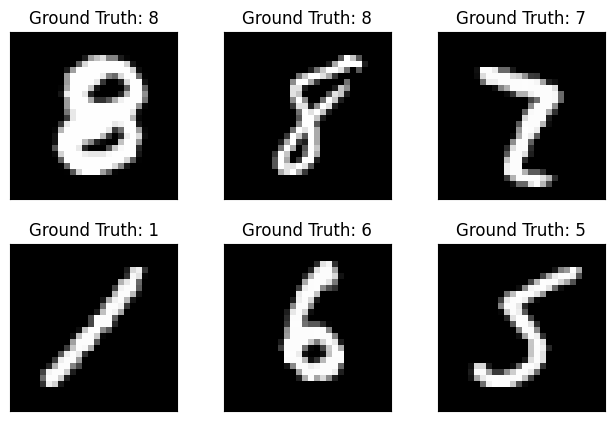

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  print(example_data[i][0].shape)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [8]:
def train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter):

  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * batch_size_train, len(train_loader.dataset),
        100 * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))


In [9]:
def test(network, test_loader, loss_fn, batch_size_test, test_losses, test_counter):

  network.eval()
  test_loss = 0
  correct = 0
  batches=0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += loss_fn(output, target ).item() * len(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss = test_loss / len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append((test_counter[-1] + len(test_loader.dataset))if len(test_counter) > 0 else 0)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Rede convolucional

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.seq=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, padding='same', kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=16, out_channels=4, padding='same', kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(196, 128),
            nn.ReLU(),
            nn.Linear(128, 10),

       )

    def forward(self, x):
        return self.seq(x)

In [ ]:
n_epochs = 50

learning_rate = .1
momentum=.1


log_interval=1

network = ConvNet().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
scheduler = sch.StepLR(optimizer, 10, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]


In [ ]:
count_parameters(network)

28526

In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  scheduler.step()


Test set: Avg. loss: 2.3067, Accuracy: 1043/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306393
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.305071
Train Epoch: 1 [8192/60000 (13%)]	Loss: 2.303083
Train Epoch: 1 [12288/60000 (20%)]	Loss: 2.304493
Train Epoch: 1 [16384/60000 (27%)]	Loss: 2.303341
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.302504
Train Epoch: 1 [24576/60000 (40%)]	Loss: 2.302689
Train Epoch: 1 [28672/60000 (47%)]	Loss: 2.300810
Train Epoch: 1 [32768/60000 (53%)]	Loss: 2.300367
Train Epoch: 1 [36864/60000 (60%)]	Loss: 2.298905
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.298723
Train Epoch: 1 [45056/60000 (73%)]	Loss: 2.297323
Train Epoch: 1 [49152/60000 (80%)]	Loss: 2.297407
Train Epoch: 1 [53248/60000 (87%)]	Loss: 2.295956
Train Epoch: 1 [57344/60000 (93%)]	Loss: 2.296438

Test set: Avg. loss: 2.2945, Accuracy: 1362/10000 (14%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.294625
Train Epoch: 2 [4096/60000 (7%)]	Loss: 2.293739
Train Epoch: 2 [8192/60000 (13%)]	Loss: 2.294942


Text(0.5, 1.0, 'Rede convolucional')

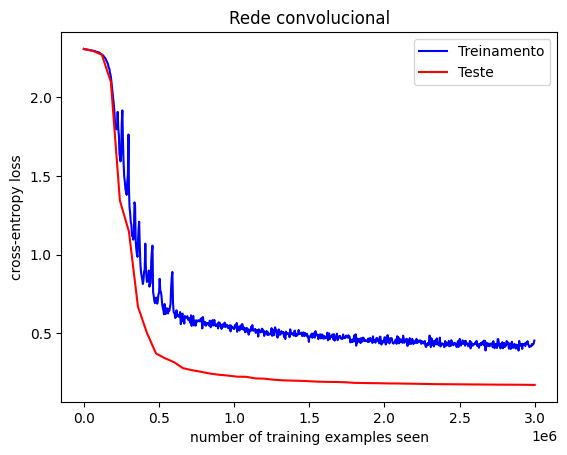

In [ ]:
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede convolucional")


## Rede Fully-Connected

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.seq=nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 10),

       )

    def forward(self, x):
        return self.seq(x)

In [ ]:
n_epochs = 50
learning_rate = 0.4
momentum=0.1
log_interval=1

network = FCNet().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
scheduler = sch.StepLR(optimizer, 10, 0.5)


train_losses = []
train_counter = []
test_losses = []
test_counter = []

In [ ]:
count_parameters(network)

26506

In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  scheduler.step()


Test set: Avg. loss: 2.3107, Accuracy: 944/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310915
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.303813
Train Epoch: 1 [8192/60000 (13%)]	Loss: 2.297845
Train Epoch: 1 [12288/60000 (20%)]	Loss: 2.282705
Train Epoch: 1 [16384/60000 (27%)]	Loss: 2.276250
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.264514
Train Epoch: 1 [24576/60000 (40%)]	Loss: 2.252792
Train Epoch: 1 [28672/60000 (47%)]	Loss: 2.236829
Train Epoch: 1 [32768/60000 (53%)]	Loss: 2.220817
Train Epoch: 1 [36864/60000 (60%)]	Loss: 2.199898
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.177378
Train Epoch: 1 [45056/60000 (73%)]	Loss: 2.144927
Train Epoch: 1 [49152/60000 (80%)]	Loss: 2.115567
Train Epoch: 1 [53248/60000 (87%)]	Loss: 2.073585
Train Epoch: 1 [57344/60000 (93%)]	Loss: 2.022103

Test set: Avg. loss: 1.9160, Accuracy: 5373/10000 (54%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.968600
Train Epoch: 2 [4096/60000 (7%)]	Loss: 1.919420
Train Epoch: 2 [8192/60000 (13%)]	Loss: 1.869354
Tr

Text(0.5, 1.0, 'Rede Fully-Connected')

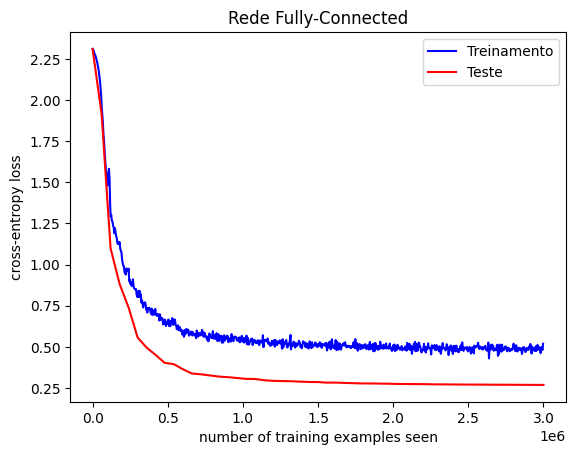

In [ ]:
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede Fully-Connected")


## Comparação de numero de parâmetros

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
print("Num de parametros")
print(f"Convolucional: {count_parameters(ConvNet())}")
print(f"FC: {count_parameters(FCNet())}")

Num de parametros
Convolucional: 28526
FC: 26506


## Convolucional + Adam

In [ ]:
n_epochs = 50

learning_rate = .001

momentum=0.1

log_interval=1

network = ConvNet().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
scheduler = sch.StepLR(optimizer, 10, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]



In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  scheduler.step()


Test set: Avg. loss: 2.3031, Accuracy: 982/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303996
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.296263
Train Epoch: 1 [8192/60000 (13%)]	Loss: 2.290402
Train Epoch: 1 [12288/60000 (20%)]	Loss: 2.282390
Train Epoch: 1 [16384/60000 (27%)]	Loss: 2.272988
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.263468
Train Epoch: 1 [24576/60000 (40%)]	Loss: 2.251238
Train Epoch: 1 [28672/60000 (47%)]	Loss: 2.239026
Train Epoch: 1 [32768/60000 (53%)]	Loss: 2.218057
Train Epoch: 1 [36864/60000 (60%)]	Loss: 2.206505
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.185431
Train Epoch: 1 [45056/60000 (73%)]	Loss: 2.158694
Train Epoch: 1 [49152/60000 (80%)]	Loss: 2.125366
Train Epoch: 1 [53248/60000 (87%)]	Loss: 2.100876
Train Epoch: 1 [57344/60000 (93%)]	Loss: 2.070155

Test set: Avg. loss: 1.9970, Accuracy: 5699/10000 (57%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.030504
Train Epoch: 2 [4096/60000 (7%)]	Loss: 1.969326
Train Epoch: 2 [8192/60000 (13%)]	Loss: 1.915569
T

Text(0.5, 1.0, 'Rede Convolucional + ADAM')

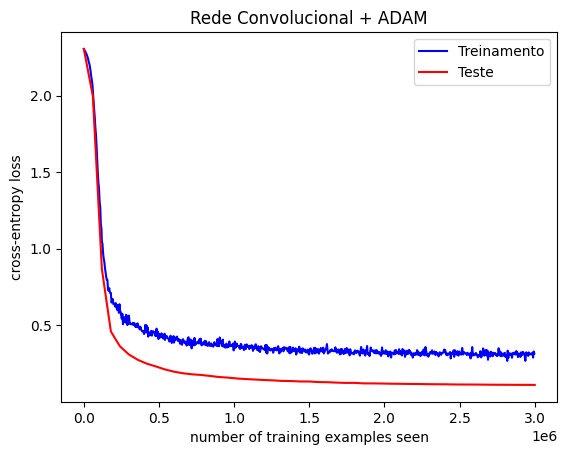

In [ ]:
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede Convolucional + ADAM")

## FC + Adam

In [ ]:
n_epochs = 50

learning_rate = .001

momentum=0.1

log_interval=1

network = FCNet().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
scheduler = sch.StepLR(optimizer, 10, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]

In [ ]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  scheduler.step()


Test set: Avg. loss: 2.3160, Accuracy: 783/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312389
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.303728
Train Epoch: 1 [8192/60000 (13%)]	Loss: 2.294565
Train Epoch: 1 [12288/60000 (20%)]	Loss: 2.281777
Train Epoch: 1 [16384/60000 (27%)]	Loss: 2.272767
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.265643
Train Epoch: 1 [24576/60000 (40%)]	Loss: 2.252801
Train Epoch: 1 [28672/60000 (47%)]	Loss: 2.238844
Train Epoch: 1 [32768/60000 (53%)]	Loss: 2.222141
Train Epoch: 1 [36864/60000 (60%)]	Loss: 2.209074
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.195002
Train Epoch: 1 [45056/60000 (73%)]	Loss: 2.178033
Train Epoch: 1 [49152/60000 (80%)]	Loss: 2.161451
Train Epoch: 1 [53248/60000 (87%)]	Loss: 2.155129
Train Epoch: 1 [57344/60000 (93%)]	Loss: 2.114325

Test set: Avg. loss: 2.0752, Accuracy: 4995/10000 (50%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.103286
Train Epoch: 2 [4096/60000 (7%)]	Loss: 2.094110
Train Epoch: 2 [8192/60000 (13%)]	Loss: 2.066585
Tr

Text(0.5, 1.0, 'Rede Fully-Connected + ADAM')

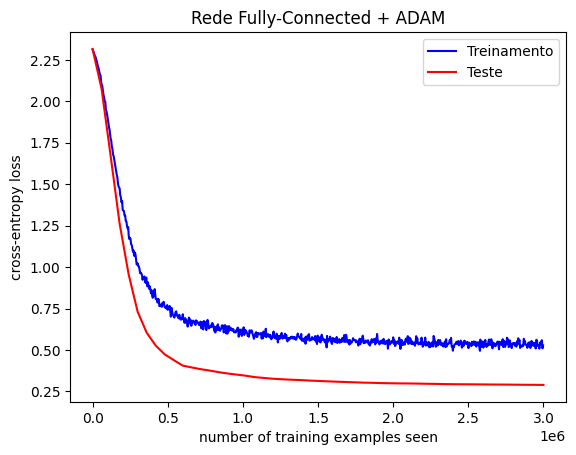

In [ ]:
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede Fully-Connected + ADAM")

## Convolucional (menor) + Adam

In [10]:
class ConvNetNano(nn.Module):
    def __init__(self):
        super(ConvNetNano, self).__init__()
        self.seq=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding='same', kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=8, out_channels=1, padding='same', kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(49, 16),
            nn.ReLU(),
            nn.Linear(16, 10),

       )

    def forward(self, x):
        return self.seq(x)

In [11]:
n_epochs = 50

learning_rate = .004

momentum=0.1

log_interval=1

network = ConvNetNano().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
scheduler = sch.StepLR(optimizer, 10, 0.5)

train_losses = []
train_counter = []
test_losses = []
test_counter=[]

In [12]:
count_parameters(network)

1379

In [13]:
test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(network, train_loader, epoch, optimizer, loss_fn, log_interval, batch_size_train, train_losses, train_counter)
  test(network, test_loader, loss_fn, batch_size_test,  test_losses, test_counter)
  scheduler.step()


Test set: Avg. loss: 2.3123, Accuracy: 1009/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310807
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.307898
Train Epoch: 1 [8192/60000 (13%)]	Loss: 2.304600
Train Epoch: 1 [12288/60000 (20%)]	Loss: 2.301713
Train Epoch: 1 [16384/60000 (27%)]	Loss: 2.294424
Train Epoch: 1 [20480/60000 (33%)]	Loss: 2.286838
Train Epoch: 1 [24576/60000 (40%)]	Loss: 2.279453
Train Epoch: 1 [28672/60000 (47%)]	Loss: 2.270255
Train Epoch: 1 [32768/60000 (53%)]	Loss: 2.253335
Train Epoch: 1 [36864/60000 (60%)]	Loss: 2.240313
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.223251
Train Epoch: 1 [45056/60000 (73%)]	Loss: 2.202113
Train Epoch: 1 [49152/60000 (80%)]	Loss: 2.168915
Train Epoch: 1 [53248/60000 (87%)]	Loss: 2.142558
Train Epoch: 1 [57344/60000 (93%)]	Loss: 2.110222

Test set: Avg. loss: 2.0256, Accuracy: 3710/10000 (37%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.089443
Train Epoch: 2 [4096/60000 (7%)]	Loss: 2.035296
Train Epoch: 2 [8192/60000 (13%)]	Loss: 2.008943


Text(0.5, 1.0, 'Rede Convolucional Nano + ADAM')

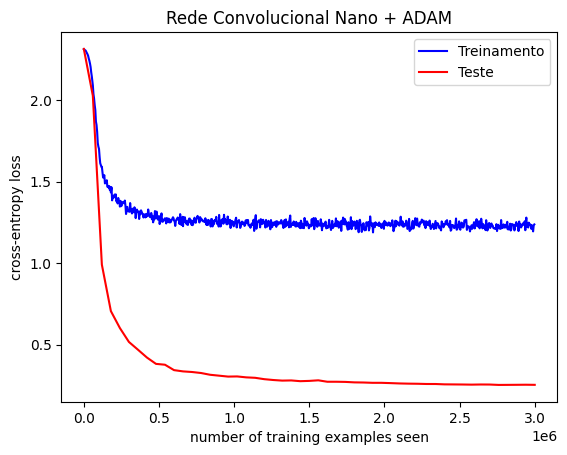

In [14]:
fig = plt.figure()
test_counter = [i*len(train_loader.dataset) for i in range(len(test_losses))]
plt.plot(train_counter, train_losses, color='blue', label='Treinamento')
plt.plot(test_counter, test_losses, color='red', label='Teste')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')
plt.legend()
plt.title("Rede Convolucional Nano + ADAM")